# Create Sentinel-2 STMs

## Load packages

In [28]:
import os
#os.environ['CRYPTOGRAPHY_OPENSSL_NO_LEGACY'] = '1'

import ee
import geemap

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


Successfully saved authorization token.


In [29]:
## Load packages 
from osgeo import ogr
from tqdm.notebook import tqdm
import json
import pandas as pd
from osgeo import gdal, osr, ogr
import geopandas as gpd
import numpy as np
import fun_fun_fun
ogr.DontUseExceptions()

## Load auxilary data

In [3]:
roiBounds = [4510470.356876345, 3436156.854304816, 4519529.956876345, 3417150.254304816]

In [4]:
# convert bounds to geometry object for usage in Earth Engine
roiGeom = ee.Geometry.Rectangle([roiBounds[0], roiBounds[3], roiBounds[2], roiBounds[1]], 'EPSG:3035', False)

## Prepare STMs 

### Sentinel-2

In [5]:
import folium

# Get the collections
s2c = fun_fun_fun.get_s2_sr_cld_col(roiGeom, '2021-01-01', '2021-12-31')

# Apply cloud and shadow masking
s2c_masked = s2c.map(fun_fun_fun.add_cld_shdw_mask).map(fun_fun_fun.apply_cld_shdw_mask)

# Reproject to 3035
s2c_masked = s2c_masked.map(fun_fun_fun.reproject_to_3035)

# calculate EVI and NDMI
s2c_masked = s2c_masked.map(fun_fun_fun.add_indices)

# Clip the Sentinel-1 data to the bounds of the geometry
s2c_clipped = s2c_masked.map(lambda img: fun_fun_fun.clip_to_geometry(img, roiGeom))

In [6]:
# Get seasonal STMs for Spring and Summer
seasonal_stm = fun_fun_fun.seasonal_STM(s2c_clipped)

In [7]:
# Split the collection into two
spring_stm = seasonal_stm.filter(ee.Filter.eq('start_month', 4))
summer_stm = seasonal_stm.filter(ee.Filter.eq('start_month', 7))

## Display and check if everything worked

In [8]:
# display the spring STM mean RGB Sentinel-2 image
#spring_stm = spring_stm.first()
spring_stm_rgb = spring_stm.select(['B4_mean', 'B3_mean', 'B2_mean'])
#spring_stm_rgb = spring_stm_rgb.visualize(min=0, max=3000, bands=['B4_mean', 'B3_mean', 'B2_mean'])
# Define visualization parameters
vis_params = {
    'bands': ['B4_mean', 'B3_mean', 'B2_mean'],  # Adjust bands as needed
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Instantiate the map and set the center, we also add a satellite basemap underneath
map02 = geemap.Map()
map02.centerObject(ee.FeatureCollection([roiGeom]), 6)
map02.add_basemap('SATELLITE')
# Load the layers
map02.addLayer(spring_stm_rgb, vis_params, f'Spring STM')
# Call the map object
map02


Map(center=[53.91140667948662, 12.952579756369222], controls=(WidgetControl(options=['position', 'transparent_…

## Combine with Sentinel-1 imagery

In [9]:
# Get the Sentinel-1 collections
s1c = fun_fun_fun.get_s1_data(roiGeom, '2021-01-01', '2021-12-31')

# Reproject to 3035
s1c_reprojected = s1c.map(fun_fun_fun.reproject_to_3035)

# Clip the Sentinel-1 data to the bounds of the geometry
s1c_clipped = s1c.map(lambda img: fun_fun_fun.clip_to_geometry(img, roiGeom))

# Apply seasonal STMs
seasonal_stms_s1 = fun_fun_fun.seasonal_STM(s1c_clipped)

# Split the collection into two for Spring and Summer
spring_stm_s1 = seasonal_stms_s1.filter(ee.Filter.eq('start_month', 4))
summer_stm_s1 = seasonal_stms_s1.filter(ee.Filter.eq('start_month', 7))


## Combine Sentinel-2 and Sentinel-1 STMs

### Seasonal STMs

In [10]:
# merge seasonal STMs
merged_spring_stm = spring_stm.merge(spring_stm_s1)
merged_summer_stm = summer_stm.merge(summer_stm_s1)

# reproject to 3035
merged_spring_stm = merged_spring_stm.map(fun_fun_fun.reproject_to_3035)
merged_summer_stm = merged_summer_stm.map(fun_fun_fun.reproject_to_3035)

In [11]:
merged_spring_stm_bands = merged_spring_stm.toBands()
merged_summer_stm_bands = merged_summer_stm.toBands()

In [12]:
merged_stm_seasonal = merged_spring_stm_bands.addBands(merged_summer_stm_bands)


# Get Training Points

In [ ]:
ptsSHP_s2 = ogr.Open('/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/sampled_points_scheme_2.gpkg')
ptsLYR_s2 = ptsSHP_s2.GetLayer()
print(ptsLYR_s2.GetFeatureCount())

# print projection
#print(ptsLYR_s2.GetSpatialRef())

550
550


## Convert into Feature Collection

In [58]:
# adapt function so it can be used with various coordinate systems and convert the crs to EPSG: 4326 
def lyrTOfc(path, epsg):
    import ee
    import json
    from osgeo import ogr, osr

    # create empty feature collection
    fc = ee.FeatureCollection([]) 

    # open path and get crs
    ds1 = ogr.Open(path)
    in_lyr = ds1.GetLayer()

    # get original crs and target crs and make transformation
    fromCS = in_lyr.GetSpatialRef()
    toCS = osr.SpatialReference()
    toCS.ImportFromEPSG(epsg)
    ct = osr.CoordinateTransformation(fromCS, toCS)

    for feat in in_lyr:
        geom = feat.GetGeometryRef() # get geometry of feature
        geom.Transform(ct) # transform geometry to target crs
        geojson = json.loads(geom.ExportToJson()) # convert geometry to geojson
        properties = {} # create empty dictionary to store properties
        for i in range(feat.GetFieldCount()): # loop through fields in feature
            field_name = feat.GetFieldDefnRef(i).GetName() # get field name
            field_value = feat.GetField(i) # get field value
            properties[field_name] = field_value # add field name and value to properties dictionary
        ee_feat = ee.Feature(ee.Geometry(geojson), properties) # create ee.Feature from geometry and properties
        ee_feat = ee_feat.set('system:index', None) # remove system:index property because it is not allowed in feature collection
        fc = fc.merge(ee.FeatureCollection(ee_feat)) # merge feature into feature collection

    return fc


In [ ]:
# use function
fc_s2 = lyrTOfc('/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/sampled_points_scheme_2.gpkg', 4326)

## Extract values at point location for seasonal STMs

#### Spring and Summer

In [21]:
vals_spring_s2 = merged_spring_stm_bands.sampleRegions(collection=fc_s2, properties=['class'], scale=10, tileScale=4, geometries=False).getInfo()
vals_summer_s2 = merged_summer_stm_bands.sampleRegions(collection=fc_s2, properties=['class'], scale=10, tileScale=4, geometries=False).getInfo()


In [22]:
flag = 0
featureValues = vals_spring_s2['features']
for f in featureValues:         
 # Check here always the right order of the indices
    prop = f['properties']
    if flag == 0:
        spring_s2_df = pd.DataFrame(prop, index=[0])
        flag = 1
    else:
        spring_s2_df = pd.concat([spring_s2_df, pd.DataFrame(prop, index=[0])])
spring_s2_df.head(10)

,1_0_B11_mean,1_0_B11_p10,1_0_B11_p25,1_0_B11_p50,1_0_B11_p75,1_0_B11_p90,1_0_B11_stdDev,1_0_B12_mean,1_0_B12_p10,1_0_B12_p25,...,2_0_VH_p90,2_0_VH_stdDev,2_0_VV_mean,2_0_VV_p10,2_0_VV_p25,2_0_VV_p50,2_0_VV_p75,2_0_VV_p90,2_0_VV_stdDev,class
0,2538.500000,1789.5,2071.0,2252.5,3122.0,3570.5,662.914964,1534.900000,895.0,1097.0,...,-13.999542,2.980351,-12.603742,-15.996234,-14.039904,-12.566989,-10.394095,-9.491818,2.467416,1
0,2283.571429,1758.0,1935.0,2179.5,2621.0,2927.0,398.027945,1327.071429,898.0,988.0,...,-14.625216,2.260348,-11.259213,-14.924210,-13.517386,-11.170302,-9.049316,-7.017263,3.184536,1
0,2213.214286,1570.0,1749.0,1996.0,2645.0,2906.0,488.962338,1265.357143,782.0,895.0,...,-13.413938,2.018526,-9.797167,-12.814116,-11.101341,-9.764776,-8.499385,-7.044710,2.110766,1
0,2134.000000,1624.5,1734.0,2028.5,2429.0,2773.5,414.020772,1152.000000,796.0,869.0,...,-16.151298,2.437366,-12.450929,-15.757983,-13.769895,-12.129517,-10.727398,-9.701439,2.585377,1
0,2419.416667,1872.0,2064.0,2226.0,2894.5,3090.0,500.049741,1468.583333,935.0,1076.0,...,-13.906836,2.271766,-12.342341,-14.299734,-13.356671,-12.316803,-11.216115,-10.774525,1.679099,1
0,1867.833333,1447.0,1683.0,1844.5,2087.0,2191.0,290.203042,975.250000,730.0,818.0,...,-16.336977,2.615194,-14.396739,-17.749394,-16.169410,-13.884162,-12.686448,-11.897296,2.466508,1
0,2733.857143,1834.0,2233.0,2460.5,3376.0,3674.0,658.411601,1652.928571,935.0,1170.0,...,-14.376517,3.672154,-12.528884,-15.451162,-14.093992,-12.685454,-11.032620,-8.745044,2.538118,1
0,2472.285714,1680.0,2000.0,2314.0,3027.0,3299.0,605.930740,1531.785714,928.0,1089.0,...,-14.996265,2.038594,-11.148162,-13.960053,-12.744004,-11.237299,-9.503399,-8.513437,2.179961,1
0,2128.125000,1617.0,1761.5,1966.5,2468.0,3016.0,486.423282,1167.375000,845.0,913.5,...,-14.485955,3.885596,-11.749103,-14.414923,-13.397179,-12.337215,-10.290562,-7.996076,2.329406,1
0,2016.357143,1150.0,1798.0,2076.5,2372.0,2415.0,417.365993,1068.785714,668.0,892.0,...,-15.107602,1.851762,-11.615155,-15.401502,-13.310791,-10.984678,-9.603920,-8.556033,2.769223,1


In [23]:
flag = 0
featureValues = vals_summer_s2['features']
for f in featureValues:         
 # Check here always the right order of the indices
    prop = f['properties']
    if flag == 0:
        summer_s2_df = pd.DataFrame(prop, index=[0])
        flag = 1
    else:
        summer_s2_df = pd.concat([summer_s2_df, pd.DataFrame(prop, index=[0])])
summer_s2_df.head(10)

,1_1_B11_mean,1_1_B11_p10,1_1_B11_p25,1_1_B11_p50,1_1_B11_p75,1_1_B11_p90,1_1_B11_stdDev,1_1_B12_mean,1_1_B12_p10,1_1_B12_p25,...,2_1_VH_p90,2_1_VH_stdDev,2_1_VV_mean,2_1_VV_p10,2_1_VV_p25,2_1_VV_p50,2_1_VV_p75,2_1_VV_p90,2_1_VV_stdDev,class
0,2668.333333,2495.0,2567.0,2688.0,2782.0,2790.0,116.625707,1353.333333,1191.0,1298.0,...,-15.580761,2.104450,-10.779090,-13.565019,-11.983315,-11.123154,-9.036569,-7.569821,2.192904,1
0,2730.166667,2601.0,2655.0,2727.0,2816.0,2855.0,88.085974,1483.000000,1256.0,1277.0,...,-15.861392,1.894411,-11.784850,-14.690579,-12.824347,-11.666077,-10.179588,-8.965111,2.342389,1
0,2293.333333,2166.0,2166.0,2300.0,2404.0,2424.0,114.309035,1129.666667,1083.0,1092.0,...,-12.726439,1.705297,-9.091552,-12.598413,-10.416954,-9.595176,-7.493980,-5.789119,2.216639,1
0,2282.000000,2173.0,2210.0,2274.5,2354.0,2406.0,84.973525,1184.500000,1058.0,1118.0,...,-14.408753,2.088658,-11.756355,-13.533400,-13.131776,-11.986475,-10.284403,-9.265685,1.804736,1
0,2808.500000,2563.0,2652.0,2795.5,3013.0,3032.0,184.823114,1448.000000,1239.0,1337.0,...,-13.729692,2.779663,-10.493286,-13.185700,-12.325145,-10.284741,-9.405126,-7.460775,2.251117,1
0,2464.500000,2424.0,2448.0,2463.0,2488.0,2501.0,25.408332,1268.333333,1194.0,1236.0,...,-17.358630,1.400568,-13.095946,-15.927275,-14.579719,-13.706028,-11.448494,-9.909904,2.240687,1
0,2809.000000,2699.0,2715.0,2843.5,2872.0,2881.0,73.659125,1545.000000,1337.0,1343.0,...,-15.035936,2.104244,-10.077426,-12.312918,-11.481572,-10.150554,-8.663372,-7.653517,1.997325,1
0,2366.333333,2049.0,2188.0,2398.0,2537.0,2628.0,209.505502,1257.333333,1087.0,1096.0,...,-15.578227,2.066563,-11.451093,-14.000169,-12.749550,-11.618650,-10.201382,-8.512607,1.893666,1
0,2489.500000,2202.0,2391.0,2489.0,2610.0,2756.0,173.811919,1287.500000,1144.0,1179.0,...,-13.922998,2.489996,-10.085537,-13.616584,-12.271490,-9.758794,-7.788321,-6.690557,2.779559,1
0,2676.800000,2354.0,2371.0,2860.0,2861.0,2938.0,258.236636,1371.600000,1183.0,1186.0,...,-17.525415,2.900697,-12.873943,-16.198354,-14.701081,-12.715343,-11.457344,-9.702970,2.345097,1


#### Combined Spring and Summer

In [24]:
vals_merged_s2 = merged_stm_seasonal.sampleRegions(collection=fc_s2, properties=['class'], scale=10, tileScale=4, geometries=False).getInfo()

In [25]:
flag = 0
featureValues = vals_merged_s2['features']
for f in featureValues:         
 # Check here always the right order of the indices
    prop = f['properties']
    if flag == 0:
        vals_merged_s2_df = pd.DataFrame(prop, index=[0])
        flag = 1
    else:
        vals_merged_s2_df = pd.concat([vals_merged_s2_df, pd.DataFrame(prop, index=[0])])
vals_merged_s2_df.head(10)

,1_0_B11_mean,1_0_B11_p10,1_0_B11_p25,1_0_B11_p50,1_0_B11_p75,1_0_B11_p90,1_0_B11_stdDev,1_0_B12_mean,1_0_B12_p10,1_0_B12_p25,...,2_1_VH_p90,2_1_VH_stdDev,2_1_VV_mean,2_1_VV_p10,2_1_VV_p25,2_1_VV_p50,2_1_VV_p75,2_1_VV_p90,2_1_VV_stdDev,class
0,2538.500000,1789.5,2071.0,2252.5,3122.0,3570.5,662.914964,1534.900000,895.0,1097.0,...,-15.580761,2.104450,-10.779090,-13.565019,-11.983315,-11.123154,-9.036569,-7.569821,2.192904,1
0,2283.571429,1758.0,1935.0,2179.5,2621.0,2927.0,398.027945,1327.071429,898.0,988.0,...,-15.861392,1.894411,-11.784850,-14.690579,-12.824347,-11.666077,-10.179588,-8.965111,2.342389,1
0,2213.214286,1570.0,1749.0,1996.0,2645.0,2906.0,488.962338,1265.357143,782.0,895.0,...,-12.726439,1.705297,-9.091552,-12.598413,-10.416954,-9.595176,-7.493980,-5.789119,2.216639,1
0,2134.000000,1624.5,1734.0,2028.5,2429.0,2773.5,414.020772,1152.000000,796.0,869.0,...,-14.408753,2.088658,-11.756355,-13.533400,-13.131776,-11.986475,-10.284403,-9.265685,1.804736,1
0,2419.416667,1872.0,2064.0,2226.0,2894.5,3090.0,500.049741,1468.583333,935.0,1076.0,...,-13.729692,2.779663,-10.493286,-13.185700,-12.325145,-10.284741,-9.405126,-7.460775,2.251117,1
0,1867.833333,1447.0,1683.0,1844.5,2087.0,2191.0,290.203042,975.250000,730.0,818.0,...,-17.358630,1.400568,-13.095946,-15.927275,-14.579719,-13.706028,-11.448494,-9.909904,2.240687,1
0,2733.857143,1834.0,2233.0,2460.5,3376.0,3674.0,658.411601,1652.928571,935.0,1170.0,...,-15.035936,2.104244,-10.077426,-12.312918,-11.481572,-10.150554,-8.663372,-7.653517,1.997325,1
0,2472.285714,1680.0,2000.0,2314.0,3027.0,3299.0,605.930740,1531.785714,928.0,1089.0,...,-15.578227,2.066563,-11.451093,-14.000169,-12.749550,-11.618650,-10.201382,-8.512607,1.893666,1
0,2128.125000,1617.0,1761.5,1966.5,2468.0,3016.0,486.423282,1167.375000,845.0,913.5,...,-13.922998,2.489996,-10.085537,-13.616584,-12.271490,-9.758794,-7.788321,-6.690557,2.779559,1
0,2016.357143,1150.0,1798.0,2076.5,2372.0,2415.0,417.365993,1068.785714,668.0,892.0,...,-17.525415,2.900697,-12.873943,-16.198354,-14.701081,-12.715343,-11.457344,-9.702970,2.345097,1


## Create synthetic mixes of training data

### Transform dataframes into right format for synthmix function seasonal STMs

#### Spring and Summer

In [ ]:
## put class column at the beginning
# spring  
first_column_3 = spring_s2_df.pop('class')
spring_s2_df.insert(0, 'ID', first_column_3)

# summer  
first_column_4 = summer_s2_df.pop('class')
summer_s2_df.insert(0, 'ID', first_column_4)

#### Spring and Summer combined 

In [ ]:
## put class column at the beginning
# merged seasons
first_column_2 = vals_merged_s2_df.pop('class') 
vals_merged_s2_df.insert(0, 'ID', first_column_2) 

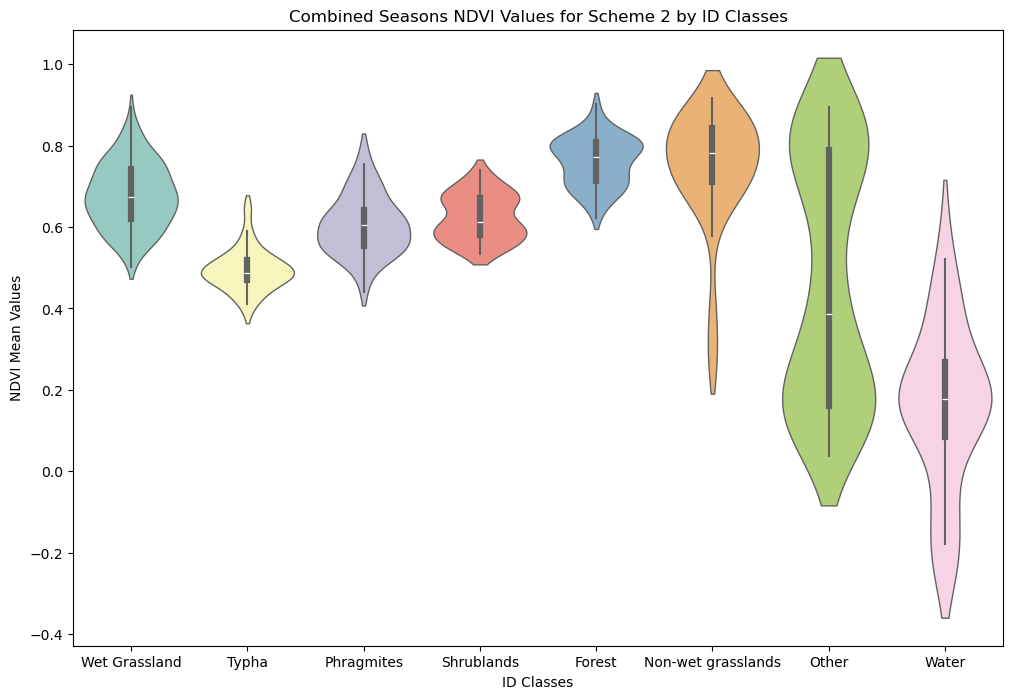

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(data=vals_merged_s2_df, x='ID', y='1_0_NDVI_mean', cut=1, linewidth=1, palette="Set3", ax=ax)

# Define the legend labels
legend_labels = ['Wet Grassland', 'Typha', 'Phragmites', 'Shrublands', 'Forest', 'Non-wet grasslands', 'Other', 'Water']

# Set the x-axis labels to the legend labels
ax.set_xticklabels(legend_labels)

# Add labels and title
ax.set_xlabel('ID Classes')
ax.set_ylabel('NDVI Mean Values')
ax.set_title('Combined Seasons NDVI Values for Scheme 2 by ID Classes')

# Show the plot
plt.show()

## Use Synthmix function

### Synthmix function

In [31]:
import numpy as np
import pandas as pd

def synthmix(df, cl_target, cl_background, n_samples=1000,
             mix_complexity=[2, 3, 4], p_mix_complexity=[0.7, 0.2, 0.1],
             within_class_mixture=True, include_endmember=True):
    """
    Generate synthetic training data mixtures from pure endmember spectra.

    Parameters:
        df (pd.DataFrame): Input dataframe. First column contains class-IDs (integers), 
                           remaining columns contain features.
        cl_target (int): Target class' integer ID value.
        cl_background (list[int]): Background class' integer ID values.
        n_samples (int): Number of synthetic training points to generate.
        mix_complexity (list[int]): Desired number of possible mixtures between classes.
        p_mix_complexity (list[float]): Probabilities for mix_complexity.
        within_class_mixture (bool): If True, allows mixtures within the same class group.
        include_endmember (bool): If True, includes original endmembers in the output.

    Returns:
        pd.DataFrame: Dataframe with linearly mixed features and target class fractions.
    """
    # Total number of classes and indices
    all_ems = [cl_target] + cl_background
    idx_em = {em: np.flatnonzero(df.iloc[:, 0].values == em) for em in all_ems}
    
    # Fraction vector for target class
    zero_one = np.zeros(len(df))
    zero_one[idx_em[cl_target]] = 1

    # Preallocate space for mixtures
    n_features = df.shape[1] - 1
    mixtures = np.zeros((n_samples, n_features + 1))
    
    for i in range(n_samples):
        # Determine mixing complexity
        complexity = (mix_complexity[0] if len(p_mix_complexity) == 1 else 
                      np.random.choice(mix_complexity, p=p_mix_complexity))
        
        # Select background classes for the mixture
        background = (np.random.choice(all_ems, complexity - 1, replace=True) if within_class_mixture 
                      else np.random.choice(cl_background, complexity - 1, replace=False))
        
        # Sample indices for target and background classes
        response = [cl_target] + list(background)
        drawn_index = [np.random.choice(idx_em[r]) for r in response]
        
        # Extract features and fractions
        drawn_features = df.iloc[drawn_index, 1:].values
        drawn_fraction = zero_one[drawn_index]
        
        # Sample random weights
        weights = np.random.dirichlet(alpha=np.ones(complexity))
        
        # Calculate mixture and fraction
        mixtures[i, :-1] = np.dot(weights, drawn_features)
        mixtures[i, -1] = np.dot(weights, drawn_fraction)
    
    # Convert mixtures to a DataFrame
    columns = list(df.columns[1:]) + ["fraction"]
    df_mixture = pd.DataFrame(mixtures, columns=columns)
    
    # Include original endmembers if specified
    if include_endmember:
        endmembers = df.iloc[:, 1:].copy()
        endmembers["fraction"] = zero_one
        df_mixture = pd.concat([df_mixture, endmembers], ignore_index=True)
    
    return df_mixture


### Synthmix for seasnonal STMs

#### Spring and Summer

In [ ]:
## Mixes
# spring
synthetic_data_scheme2_wetgrassland_spring = synthmix(spring_s2_df, cl_target=1, cl_background=[2, 3, 4, 5, 6, 7, 8], n_samples=1000) # Wet-Grasslands

synthetic_data_scheme2_Typha_spring = synthmix(spring_s2_df, cl_target=2, cl_background=[1, 3, 4, 5, 6, 7, 8], n_samples=1000) # Typha

synthetic_data_scheme2_Phragmites_spring = synthmix(spring_s2_df, cl_target=3, cl_background=[1, 2, 4, 5, 6, 7, 8], n_samples=1000) # Phragmites

synthetic_data_scheme2_shrubland_spring = synthmix(spring_s2_df, cl_target=4, cl_background=[1, 2, 3, 5, 6, 7, 8], n_samples=1000) # Shrublands

synthetic_data_scheme2_water_spring = synthmix(spring_s2_df, cl_target=8, cl_background=[1, 2, 3, 4, 5, 6, 7], n_samples=1000) # Water

# summer
synthetic_data_scheme2_wetgrassland_summer = synthmix(summer_s2_df, cl_target=1, cl_background=[2, 3, 4, 5, 6, 7, 8], n_samples=1000) # Wet-Grasslands

synthetic_data_scheme2_Typha_summer = synthmix(summer_s2_df, cl_target=2, cl_background=[1, 3, 4, 5, 6, 7, 8], n_samples=1000) # Typha

synthetic_data_scheme2_Phragmites_summer = synthmix(summer_s2_df, cl_target=3, cl_background=[1, 2, 4, 5, 6, 7, 8], n_samples=1000) # Phragmites

synthetic_data_scheme2_shrubland_summer = synthmix(summer_s2_df, cl_target=4, cl_background=[1, 2, 3, 5, 6, 7, 8], n_samples=1000) # Shrublands

synthetic_data_scheme2_water_summer = synthmix(summer_s2_df, cl_target=8, cl_background=[1, 2, 3, 4, 5, 6, 7], n_samples=1000) # Water

#### Spring and Summer combined

In [ ]:
## Mixes
# Scheme 2
synthetic_data_scheme2_wetgrassland_merged = synthmix(vals_merged_s2_df, cl_target=1, cl_background=[2, 3, 4, 5, 6, 7, 8], n_samples=1000) # Wet-Grasslands

synthetic_data_scheme2_Typha_merged = synthmix(vals_merged_s2_df, cl_target=2, cl_background=[1, 3, 4, 5, 6, 7, 8], n_samples=1000) # Typha

synthetic_data_scheme2_Phragmites_merged = synthmix(vals_merged_s2_df, cl_target=3, cl_background=[1, 2, 4, 5, 6, 7, 8], n_samples=1000) # Phragmites

synthetic_data_scheme2_shrubland_merged = synthmix(vals_merged_s2_df, cl_target=4, cl_background=[1, 2, 3, 5, 6, 7, 8], n_samples=1000) # Shrublands

synthetic_data_scheme2_water_merged = synthmix(vals_merged_s2_df, cl_target=8, cl_background=[1, 2, 3, 4, 5, 6, 7], n_samples=1000) # Water

## Train Random Forest Regression Model

#### Note: Validation with AVIRIS-NG classifcation map is at the end of the Notebook. 

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


### Seasonal STMs

#### Spring and Summer

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from geemap import ml

def train_model(data, param_grid, test_size=0.2, random_state=42):
    # Create the two arrays
    y = data['fraction']
    X = data.drop(['fraction'], axis=1)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create a classifier instance
    RF = RandomForestRegressor(random_state=random_state)
    RF_cv = GridSearchCV(RF, param_grid=param_grid, cv=3, refit=True, n_jobs=4).fit(X_train, y_train)
    
    # Get the best model
    best_model = RF_cv.best_estimator_

    # Predict the test data
    y_pred = best_model.predict(X_test)

    # Calculate the mean squared error and mean absolute error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Get F1 score and accuracy
    r2 = r2_score(y_test, y_pred)
    
    # Convert the model to a string and then to an Earth Engine classifier
    feature_names = X.columns.tolist()
    best_mod_str = ml.rf_to_strings(best_model, feature_names, output_mode="REGRESSION")
    ee_classifier = ml.strings_to_classifier(best_mod_str)
    
    return best_model, ee_classifier, mse, mae, r2

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [5, 10, 'sqrt'],
    'min_samples_split': [5, 10, 15],
    'max_depth': [5, 10, 20]
}

# Define the synthetic datasets
synthetic_datasets = {
    'spring_wetgrassland': synthetic_data_scheme2_wetgrassland_spring,
    'spring_Typha': synthetic_data_scheme2_Typha_spring,
    'spring_Phragmites': synthetic_data_scheme2_Phragmites_spring,
    'spring_shrubland': synthetic_data_scheme2_shrubland_spring,
    'spring_water': synthetic_data_scheme2_water_spring,
    'summer_wetgrassland': synthetic_data_scheme2_wetgrassland_summer,
    'summer_Typha': synthetic_data_scheme2_Typha_summer,
    'summer_Phragmites': synthetic_data_scheme2_Phragmites_summer,
    'summer_shrubland': synthetic_data_scheme2_shrubland_summer,
    'summer_water': synthetic_data_scheme2_water_summer
}

# Train models for all synthetic datasets
models = {}
ee_classifiers = {}
mse_dict = {}
mae_dict = {}
r2_dict = {}
for name, data in synthetic_datasets.items():
    best_model, ee_classifier, mse, mae, r2 = train_model(data, param_grid)
    models[name] = best_model
    ee_classifiers[name] = ee_classifier
    mse_dict[name] = mse
    mae_dict[name] = mae
    r2_dict[name] = r2



In [49]:
# Access models and classifiers for each synthetic dataset
for name in synthetic_datasets.keys():
    best_model = models[name]
    ee_classifier = ee_classifiers[name]
    mse = mse_dict[name]
    mae = mae_dict[name]
    r2 = r2_dict[name]
    #print(f"Model for {name}: {best_model}")
    #print(f"EE Classifier for {name}: {ee_classifier}")
    print(f"MSE for {name}: {mse}")
    print(f"MAE for {name}: {mae}")
    print(f"R2 for {name}: {r2}")

MSE for spring_wetgrassland: 0.045003693923169455
MAE for spring_wetgrassland: 0.16581572401093778
R2 for spring_wetgrassland: 0.6949464023220131
MSE for spring_Typha: 0.01656297149467283
MAE for spring_Typha: 0.09806425868088874
R2 for spring_Typha: 0.8702253907278416
MSE for spring_Phragmites: 0.031465877909093574
MAE for spring_Phragmites: 0.13606483609060818
R2 for spring_Phragmites: 0.7706172136193438
MSE for spring_shrubland: 0.018066419052595085
MAE for spring_shrubland: 0.10419745832203654
R2 for spring_shrubland: 0.8600422594388359
MSE for spring_water: 0.009721638249961027
MAE for spring_water: 0.05909174715849724
R2 for spring_water: 0.9296340602206177
MSE for summer_wetgrassland: 0.05763275273633791
MAE for summer_wetgrassland: 0.18549696988947123
R2 for summer_wetgrassland: 0.5989727292768556
MSE for summer_Typha: 0.0283701251571083
MAE for summer_Typha: 0.1290585711758533
R2 for summer_Typha: 0.7968716746447223
MSE for summer_Phragmites: 0.03846551254636391
MAE for summer

#### Spring and Summer combined

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from geemap import ml

def train_model(data, param_grid, test_size=0.2, random_state=42):
    # Create the two arrays
    y = data['fraction']
    X = data.drop(['fraction'], axis=1)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create a classifier instance
    RF = RandomForestRegressor(random_state=random_state)
    RF_cv = GridSearchCV(RF, param_grid=param_grid, cv=3, refit=True, n_jobs=4).fit(X_train, y_train)
    
    # Get the best model
    best_model = RF_cv.best_estimator_

    # Predict the test data
    y_pred = best_model.predict(X_test)

    # Calculate the mean squared error and mean absolute error
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Get F1 score and accuracy
    r2 = r2_score(y_test, y_pred)
    
    # Convert the model to a string and then to an Earth Engine classifier
    feature_names = X.columns.tolist()
    best_mod_str = ml.rf_to_strings(best_model, feature_names, output_mode="REGRESSION")
    ee_classifier = ml.strings_to_classifier(best_mod_str)
    
    return best_model, ee_classifier, mse, mae, r2

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [5, 10, 'sqrt'],
    'min_samples_split': [5, 10, 15],
    'max_depth': [5, 10, 20]
}

# Define the synthetic datasets
synthetic_datasets = {
    'merged_wetgrassland': synthetic_data_scheme2_wetgrassland_merged,
    'merged_Typha': synthetic_data_scheme2_Typha_merged,
    'merged_Phragmites': synthetic_data_scheme2_Phragmites_merged,
    'merged_shrubland': synthetic_data_scheme2_shrubland_merged,
    'merged_water': synthetic_data_scheme2_water_merged
}

# Train models for all synthetic datasets
models = {}
ee_classifiers = {}
mse_dict = {}
mae_dict = {}
r2_dict = {}
for name, data in synthetic_datasets.items():
    best_model, ee_classifier, mse, mae, r2 = train_model(data, param_grid)
    models[name] = best_model
    ee_classifiers[name] = ee_classifier
    mse_dict[name] = mse
    mae_dict[name] = mae
    r2_dict[name] = r2



In [51]:
# Access models and classifiers for each synthetic dataset
for name in synthetic_datasets.keys():
    best_model = models[name]
    ee_classifier = ee_classifiers[name]
    mse = mse_dict[name]
    mae = mae_dict[name]
    r2 = r2_dict[name]
    #print(f"Model for {name}: {best_model}")
    #print(f"EE Classifier for {name}: {ee_classifier}")
    print(f"MSE for {name}: {mse}")
    print(f"MAE for {name}: {mae}")
    print(f"R2 for {name}: {r2}")

MSE for merged_wetgrassland: 0.043356576645299405
MAE for merged_wetgrassland: 0.16215365362653794
R2 for merged_wetgrassland: 0.7251785860837241
MSE for merged_Typha: 0.017376242294384933
MAE for merged_Typha: 0.10514081481943803
R2 for merged_Typha: 0.8738430314637378
MSE for merged_Phragmites: 0.02923125397479271
MAE for merged_Phragmites: 0.13591952619884926
R2 for merged_Phragmites: 0.7896193791209278
MSE for merged_shrubland: 0.019910449493818577
MAE for merged_shrubland: 0.11128291323433694
R2 for merged_shrubland: 0.8453986612805563
MSE for merged_water: 0.008028585045690224
MAE for merged_water: 0.052767188434399113
R2 for merged_water: 0.9330085930206713


In [52]:
# Get feature importances
model_importance = models['merged_Typha']
feature_importances = model_importance.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

           Feature  Importance
67    1_0_NDVI_p75    0.045889
39     1_0_B8A_p75    0.035407
68    1_0_NDVI_p90    0.034413
52     1_0_EVI_p50    0.028877
1      1_0_B11_p10    0.026469
..             ...         ...
167  2_1_VV_stdDev    0.000905
85      1_1_B2_p10    0.000834
94      1_1_B3_p50    0.000797
88      1_1_B2_p75    0.000636
84     1_1_B2_mean    0.000576

[168 rows x 2 columns]


## Predict in GEE

### Seasons

#### Spring and summer 

In [179]:
import ee
from geemap import ml

def classify_and_export(image, classifier, description, folder, file_name_prefix, region, scale=10):
    # Classify the image
    classification = image.classify(classifier)
    
    # Export the classified image to Google Drive
    task = ee.batch.Export.image.toDrive(
        image=classification,
        description=description,
        folder=folder,
        fileNamePrefix=file_name_prefix,
        region=region,
        scale=scale
    )
    task.start()

# Define the parameters
folder = 'geopy'
region = roiGeom
scale = 10

# Define the images and classifiers
images = {
    'spring': merged_spring_stm_bands,
    'summer': merged_summer_stm_bands
}

# classifiers = {
#     'spring_wetgrassland': ee_classifier_spring_cs2_wetgrassland,
#     'spring_Typha': ee_classifier_spring_cs2_Typha,
#     'spring_Phragmites': ee_classifier_spring_cs2_Phragmites,
#     'spring_shrubland': ee_classifier_spring_cs2_shrubland,
#     'spring_water': ee_classifier_spring_cs2_water,
#     'summer_wetgrassland': ee_classifier_summer_cs2_wetgrassland,
#     'summer_Typha': ee_classifier_summer_cs2_Typha,
#     'summer_Phragmites': ee_classifier_summer_cs2_Phragmites,
#     'summer_shrubland': ee_classifier_summer_cs2_shrubland,
#     'summer_water': ee_classifier_summer_cs2_water
# }

# Classify and export all images
for season, image in images.items():
    for landcover, classifier in ee_classifiers.items():
        if season in landcover:
            description = f'Peatland_{season}_Scheme2_{landcover.split("_")[1]}'
            file_name_prefix = f'Peatland_{season}_Scheme2_{landcover.split("_")[1]}'
            classify_and_export(image, classifier, description, folder, file_name_prefix, region, scale)

#### Spring and Summer combined

In [184]:
import ee
from geemap import ml

def classify_and_export(image, classifier, description, folder, file_name_prefix, region, scale=10):
    # Classify the image
    classification = image.classify(classifier)
    
    # Export the classified image to Google Drive
    task = ee.batch.Export.image.toDrive(
        image=classification,
        description=description,
        folder=folder,
        fileNamePrefix=file_name_prefix,
        region=region,
        scale=scale
    )
    task.start()

# Define the parameters
folder = 'geopy'
region = roiGeom
scale = 10

# Define the images and classifiers
images = {
    'merged': merged_stm_seasonal
}

# classifiers = {
#     'spring_wetgrassland': ee_classifier_spring_cs2_wetgrassland,
#     'spring_Typha': ee_classifier_spring_cs2_Typha,
#     'spring_Phragmites': ee_classifier_spring_cs2_Phragmites,
#     'spring_shrubland': ee_classifier_spring_cs2_shrubland,
#     'spring_water': ee_classifier_spring_cs2_water,
#     'summer_wetgrassland': ee_classifier_summer_cs2_wetgrassland,
#     'summer_Typha': ee_classifier_summer_cs2_Typha,
#     'summer_Phragmites': ee_classifier_summer_cs2_Phragmites,
#     'summer_shrubland': ee_classifier_summer_cs2_shrubland,
#     'summer_water': ee_classifier_summer_cs2_water
# }

# Classify and export all images
for season, image in images.items():
    for landcover, classifier in ee_classifiers.items():
        if season in landcover:
            description = f'Peatland_{season}_Scheme2_{landcover.split("_")[1]}'
            file_name_prefix = f'Peatland_{season}_Scheme2_{landcover.split("_")[1]}'
            classify_and_export(image, classifier, description, folder, file_name_prefix, region, scale)

## Validate fraction map from best model

### Resample AVIRIS-NG map

In [ ]:
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
import numpy as np

# Path
high_res_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_3035.tif'
resampled_folder = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/resampled_fractions/'

# land cover classes
landcover_classes = {
    1: "Phalaris",
    2: "Typha",
    3: "Phragmites",
    4: "Shrublands",
    5: "Forest",
    6: "Non-wet grasslands",
    7: "Settlements",
    8: "Croplands",
    9: "Water bodies",
    10: "Wet grasslands",
    11: "Carex"
}

# create fraction maps
with rasterio.open(high_res_path) as src:
    # scale
    target_resolution = 10
    scale_factor = target_resolution / src.res[0]
    width = int(src.width / scale_factor)
    height = int(src.height / scale_factor)
    
    # load data
    high_res_data = src.read(1)
    
    # Initiualize new data
    resampled_data = {class_id: np.zeros((height, width), dtype=np.float32) for class_id in landcover_classes.keys()}
    
    # create fractions
    for i in range(height):
        for j in range(width):
            # make out high_res pixels which are in the new pixel
            high_res_pixels = high_res_data[
                int(i*scale_factor):int((i+1)*scale_factor),
                int(j*scale_factor):int((j+1)*scale_factor)
            ]
            
            # calculate fractions
            unique, counts = np.unique(high_res_pixels, return_counts=True)
            fractions = dict(zip(unique, counts / high_res_pixels.size))
            
            # save everything
            for class_id in landcover_classes.keys():
                if class_id in [1, 11]:  # Phalaris und Carex zu Wet grasslands 
                    resampled_data[10][i, j] += fractions.get(class_id, 0)
                else:
                    resampled_data[class_id][i, j] = fractions.get(class_id, 0)
    
    # update transform
    transform = from_origin(src.bounds.left, src.bounds.top, target_resolution, target_resolution)
    
    # uodate metadata
    resampled_meta = src.meta.copy()
    resampled_meta.update({
        'transform': transform,
        'width': width,
        'height': height,
        'count': 1,
        'dtype': 'float32'
    })
    
    # save
    for class_id, class_name in landcover_classes.items():
        if class_id in [1, 11]:
            continue  # dont separate phalaris and carex
        resampled_class_path = f'{resampled_folder}/{class_name}_fraction.tif'
        with rasterio.open(resampled_class_path, 'w', **resampled_meta) as dst:
            dst.write(resampled_data[class_id], 1)
            # Debugging
            print(f'{class_name} - Min: {resampled_data[class_id].min()}, Max: {resampled_data[class_id].max()}')

Typha - Min: 0.0, Max: 1.0
Phragmites - Min: 0.0, Max: 1.0
Shrublands - Min: 0.0, Max: 1.0
Forest - Min: 0.0, Max: 1.0
Non-wet grasslands - Min: 0.0, Max: 1.0
Settlements - Min: 0.0, Max: 1.0
Croplands - Min: 0.0, Max: 1.0
Water bodies - Min: 0.0, Max: 1.0
Wet grasslands - Min: 0.0, Max: 1.0


### Calculate statistics

In [ ]:
import numpy as np
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import rasterio

# Path
fraction_maps = {
    'merged': {
        'Typha': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Typha.tif',
        'Phragmites': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Phragmites.tif',
        'Wet grasslands': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_wetgrassland.tif',
        'Shrublands': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_shrubland.tif',
        'Water bodies': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_water.tif'
    },
    'spring': {
        'Typha': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_spring_Scheme2_Typha.tif',
        'Phragmites': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_spring_Scheme2_Phragmites.tif',
        'Wet grasslands': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_spring_Scheme2_wetgrassland.tif',
        'Shrublands': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_spring_Scheme2_shrubland.tif',
        'Water bodies': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_spring_Scheme2_water.tif'
    },
    'summer': {
        'Typha': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/summer/Peatland_summer_Scheme2_Typha.tif',
        'Phragmites': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/summer/Peatland_summer_Scheme2_Phragmites.tif',
        'Wet grasslands': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/summer/Peatland_summer_Scheme2_wetgrassland.tif',
        'Shrublands': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/summer/Peatland_summer_Scheme2_shrubland.tif',
        'Water bodies': '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/summer/Peatland_summer_Scheme2_water.tif'
    }
}

# Paht to validation fractions
resampled_folder = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/resampled_fractions'

# sample size
num_samples = 50

# generate random points
def generate_random_points(transform, width, height, num_points):
    points = []
    for _ in range(num_points):
        x = random.uniform(0, width)
        y = random.uniform(0, height)
        lon, lat = transform * (x, y)
        points.append((lon, lat))
    return points

# iterate over all models
for model_name, model_maps in fraction_maps.items():
    print(f'\nModel: {model_name}')
    
    # iterate over fractions
    for class_name, fraction_path in model_maps.items():
        resampled_class_path = f'{resampled_folder}/{class_name}_fraction.tif'
        
        with rasterio.open(resampled_class_path) as resampled_src:
            resampled_data = resampled_src.read(1)
            resampled_transform = resampled_src.transform
            
            with rasterio.open(fraction_path) as fraction_src:
                fraction_data = fraction_src.read(1)
                fraction_transform = fraction_src.transform
                
                # generate random points
                height, width = resampled_data.shape
                sample_points = generate_random_points(resampled_transform, width, height, num_samples)
                
                # extract values
                resampled_samples = []
                fraction_samples = []
                for lon, lat in sample_points:
                    resampled_row, resampled_col = ~resampled_transform * (lon, lat)
                    fraction_row, fraction_col = ~fraction_transform * (lon, lat)
                    
                    resampled_row = int(resampled_row)
                    resampled_col = int(resampled_col)
                    fraction_row = int(fraction_row)
                    fraction_col = int(fraction_col)
                    
                    if (0 <= resampled_row < height and 0 <= resampled_col < width and
                        0 <= fraction_row < height and 0 <= fraction_col < width):
                        resampled_samples.append(resampled_data[resampled_row, resampled_col])
                        fraction_samples.append(fraction_data[fraction_row, fraction_col])
                
                # calculate metrics
                mae = mean_absolute_error(resampled_samples, fraction_samples)
                mse = mean_squared_error(resampled_samples, fraction_samples)
                
                print(f'{class_name}:')
                print(f'  MAE: {mae}')
                print(f'  MSE: {mse}')


Model: merged
Typha:
  MAE: 0.07399841398000717
  MSE: 0.007799618877470493
Phragmites:
  MAE: 0.1261691153049469
  MSE: 0.0352616012096405
Wet grasslands:
  MAE: 0.16310077905654907
  MSE: 0.04778272286057472
Shrublands:
  MAE: 0.10528798401355743
  MSE: 0.018018048256635666
Water bodies:
  MAE: 0.039817243814468384
  MSE: 0.0029006667900830507

Model: spring
Typha:
  MAE: 0.06663722544908524
  MSE: 0.006235221400856972
Phragmites:
  MAE: 0.12738332152366638
  MSE: 0.03198568895459175
Wet grasslands:
  MAE: 0.20084317028522491
  MSE: 0.06149919331073761
Shrublands:
  MAE: 0.12000137567520142
  MSE: 0.024559471756219864
Water bodies:
  MAE: 0.06835003942251205
  MSE: 0.021410128101706505

Model: summer
Typha:
  MAE: 0.12357237935066223
  MSE: 0.029274512082338333
Phragmites:
  MAE: 0.13370269536972046
  MSE: 0.027895338833332062
Wet grasslands:
  MAE: 0.18457883596420288
  MSE: 0.07657622545957565
Shrublands:
  MAE: 0.10932508856058121
  MSE: 0.0250186026096344
Water bodies:
  MAE: 0.

## Create figure for endmember feature space

In [54]:
import geopandas as gpd

points=gpd.read_file('/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/sampled_points_scheme_2.gpkg')

# Group by class ID and get the unique class names
class_info = points.groupby('class')['class_name'].unique()

# Print the class number and corresponding class name
for class_id, class_names in class_info.items():
    print(f"Class ID: {class_id}, Class Name(s): {', '.join(class_names)}")

Class ID: 1, Class Name(s): Wet Grassland
Class ID: 2, Class Name(s): Typha
Class ID: 3, Class Name(s): Phragmites
Class ID: 4, Class Name(s): Shrublands
Class ID: 5, Class Name(s): Forest
Class ID: 6, Class Name(s): Non-wet grasslands
Class ID: 7, Class Name(s): Other
Class ID: 8, Class Name(s): Water


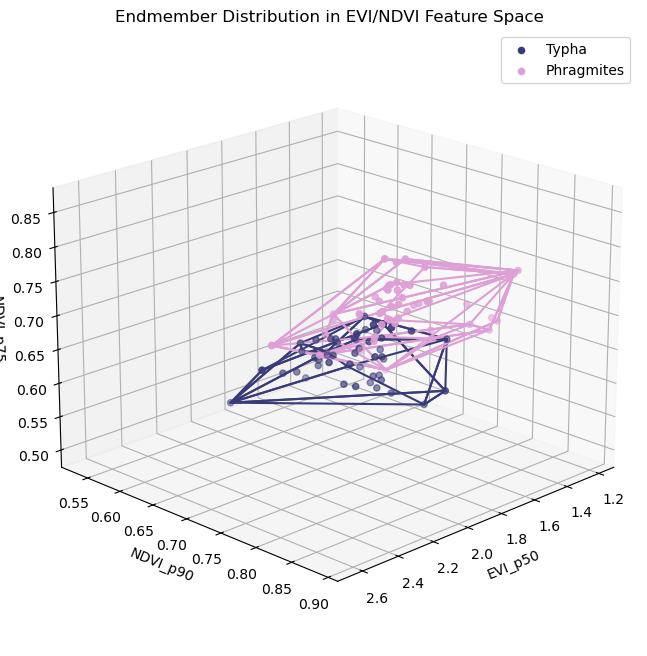

In [55]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

# 52      1_0_EVI_p50    0.048641
# 68     1_0_NDVI_p90    0.041193
# 67     1_0_NDVI_p75 

# Check the first few rows to understand the structure
gdf = vals_merged_s2_df.copy()
vals_merged_s2_df.head()

# Extract relevant columns (adjust column names if needed)
endmembers = gdf[['ID', '1_0_EVI_p50', '1_0_NDVI_p90', '1_0_NDVI_p75']]

# get relevant classes
classes = [2, 3] # Wet-Grasslands, Typha, Phragmites 

# Filter endmembers to include only specific classes
endmembers = endmembers[endmembers['ID'].isin(classes)]

# Convert to NumPy array for plotting
points = endmembers[['1_0_EVI_p50', '1_0_NDVI_p90', '1_0_NDVI_p75']].values
labels = endmembers['ID'].values

# Create a colormap
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab20b', len(unique_labels))

# Create a dictionary to map labels to colors
label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

# Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color per class
label_names = {2: 'Typha', 3: 'Phragmites'}

for label in unique_labels:
    idx = labels == label
    ax.scatter(points[idx, 0], points[idx, 1], points[idx, 2], c=[label_to_color[label]], label=label_names[label], marker='o')

# Calculate and plot the convex hull for each class
for label in unique_labels:
    class_points = points[labels == label]
    hull = ConvexHull(class_points)
    for simplex in hull.simplices:
        ax.plot(class_points[simplex, 0], class_points[simplex, 1], class_points[simplex, 2], c=label_to_color[label])

# Set labels and title
ax.set_xlabel("EVI_p50")
ax.set_ylabel("NDVI_p90")
ax.set_zlabel("NDVI_p75")
ax.set_title("Endmember Distribution in EVI/NDVI Feature Space")

# Adjust view
ax.view_init(elev=20, azim=45)

# Add legend
ax.legend()

plt.show()

## Calculate Vegetations fractions inside peatland boundary

### Extract exact outline of Arasumani et al. AVIRIS-NG classification map

In [56]:
# read file
path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification.gpkg'
gdf = gpd.read_file(path)

# first unionize the geometries and then extract boundary
outline = gdf.geometry.union_all().convex_hull

In [20]:
# save outline as geopackage
outline_gdf = gpd.GeoDataFrame(geometry=[outline], crs=gdf.crs)

# reprojct to epsg 3035
outline_gdf = outline_gdf.to_crs(epsg=3035)

outline_gdf.to_file('/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_outline.gpkg', driver='GPKG')

#### Get the peatland boundaries shapefile from Greifswald Moor Centrum here: https://www.greifswaldmoor.de/files/dokumente/GMC%20Schriften/DEU_orgBod_GMC_202105/DEU_orgBod_GMC_update202105.zip

In [ ]:
# define paths
img_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_Spring_Summer_Scheme1.tif'
petland_boundaries_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/DEU_orgBod_GMC_update202105.shp'

# read data
fmap_l1 = gdal.Open(img_path)
fmap_l1_rast = fmap_l1.ReadAsArray()

peat_bounds = ogr.Open(petland_boundaries_path)
peat_bounds_lyr = peat_bounds.GetLayer()

#### Reproject Greifswald Moor Centrum shapefile to EPSG 3035 and clip to raster extent

In [64]:
# get geometries of peatland boundaries for reprojecting
peat_geometry_feat = peat_bounds_lyr[0]
peat_geometry = peat_geometry_feat.geometry()

In [ ]:
# reproject peatland boundaries to EPSG:3035
# Create the rule for transforming coordinates from one spatial reference to another
fromCS = peat_bounds_lyr.GetSpatialRef()
toCS = fmap_l1.GetSpatialRef()
toCS.ImportFromEPSG(3035)
ct = osr.CoordinateTransformation(fromCS, toCS)

In [ ]:
# save to file
driver = ogr.GetDriverByName('ESRI Shapefile')
peat_geometry_shp = driver.CreateDataSource('/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/peatland_boundaries_epsg3035.shp')
peat_geometry_lyr = peat_geometry_shp.CreateLayer('', geom_type=ogr.wkbPolygon)

# Copy the fields from the input layer to the output layer
inLayerDefn = peat_bounds_lyr.GetLayerDefn()
for i in range(inLayerDefn.GetFieldCount()):
    fieldDefn = inLayerDefn.GetFieldDefn(i)
    peat_geometry_lyr.CreateField(fieldDefn)

# Reproject each feature and add it to the output layer
for feature in peat_bounds_lyr:
    geom = feature.GetGeometryRef()
    geom.Transform(ct)
    outFeature = ogr.Feature(peat_geometry_lyr.GetLayerDefn())
    outFeature.SetGeometry(geom)
    for i in range(feature.GetFieldCount()):
        outFeature.SetField(i, feature.GetField(i))
    peat_geometry_lyr.CreateFeature(outFeature)
    outFeature = None

# Clean up
peat_bounds = None
peat_geometry_shp = None


In [ ]:
# now clip the peatland boundary shapefile to the extent og the raster
ulx, xres, xskew, uly, yskew, yres = fmap_l1.GetGeoTransform()
sizeX = fmap_l1.RasterXSize * xres
sizeY = fmap_l1.RasterYSize * yres
lrx = ulx + sizeX
lry = uly + sizeY

# Open the input shapefile
peat_bounds_3035 = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/peatland_boundaries_epsg3035.shp'
driver = ogr.GetDriverByName('ESRI Shapefile')
inVector = driver.Open(peat_bounds_3035, 0)
inLayer = inVector.GetLayer()

# Create the output shapefile
peat_bounds_3035_clipped = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/peatland_boundaries_epsg3035_clipped.shp'

# Assign the coordinate system
srs = osr.SpatialReference()
srs.ImportFromEPSG(3035)

if driver.Open(peat_bounds_3035_clipped, 0):
    driver.DeleteDataSource(peat_bounds_3035_clipped)
outVector = driver.CreateDataSource(peat_bounds_3035_clipped)
outLayer = outVector.CreateLayer('', srs, geom_type=ogr.wkbPolygon)

# Copy the fields from the input layer to the output layer
inLayerDefn = inLayer.GetLayerDefn()
for i in range(inLayerDefn.GetFieldCount()):
    fieldDefn = inLayerDefn.GetFieldDefn(i)
    outLayer.CreateField(fieldDefn)

# Create a spatial filter using the raster extent
extent = (ulx, lry, lrx, uly)
inLayer.SetSpatialFilterRect(*extent)

# Copy the features from the input layer to the output layer
for feature in inLayer:
    geom = feature.GetGeometryRef()
    if not geom.IsValid():
        geom = geom.MakeValid()  # Fix invalid geometries
    outFeature = ogr.Feature(outLayer.GetLayerDefn())
    outFeature.SetGeometry(geom)
    for i in range(feature.GetFieldCount()):
        outFeature.SetField(i, feature.GetField(i))
    outLayer.CreateFeature(outFeature)
    outFeature = None


# Clean up
inVector = None
outVector = None



#### Clip fraction map to outline of Arasumani et al. AVIRIS-NG classification map

In [22]:
from osgeo import gdal, ogr

# Define the input and output file paths
img_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_Spring_Summer_Scheme1.tif'
clipped_fmap_l1 = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_Spring_Summer_Scheme1_clipped_Arasumani.tif'
outline_gdf = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_outline.gpkg'

# Clip the raster using the shapefile
OutTile = gdal.Warp(clipped_fmap_l1, 
                    img_path, 
                    cutlineDSName=outline_gdf,
                    cropToCutline=True,
                    dstNodata=0)

# Check if the operation was successful
if OutTile is None:
    print("Clipping failed.")
else:
    print("Clipping successful.")

Clipping successful.


#### Clip to peatland boundaries

In [ ]:
from osgeo import gdal, ogr

# Define the input and output file paths
img_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_Spring_Summer_Scheme1_clipped_Arasumani.tif'
cropped_fmap_l1 = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_Spring_Summer_Scheme1_cropped.tif'
peat_bounds_3035_clipped = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/peatland_boundaries_epsg3035_clipped.shp'


# Clip the raster using the shapefile
OutTile = gdal.Warp(cropped_fmap_l1, 
                    img_path, 
                    cutlineDSName=peat_bounds_3035_clipped,
                    cropToCutline=True,
                    dstNodata=0)

# Check if the operation was successful
if OutTile is None:
    print("Clipping failed.")
else:
    print("Clipping successful.")

### Clip best scheme 2 result to Greifswald Moor Centrum peatland boundary layer

In [ ]:
import os
from osgeo import gdal, ogr

# Define paths
typha_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Typha.tif'
phragmites_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Phragmites.tif'
outline_gdf = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/GitHub/geopy_map/AVIRIS/aviris_classification_outline.gpkg'

# Function to clip raster using shapefile
def clip_raster(input_raster_path, output_raster_path, shapefile_path):
    OutTile = gdal.Warp(output_raster_path, 
                        input_raster_path, 
                        cutlineDSName=shapefile_path, 
                        cropToCutline=True, 
                        dstNodata=0)

    # Check if the operation was successful
    if OutTile is None:
        print(f"Clipping {input_raster_path} failed.")
    else:
        print(f"Clipping {input_raster_path} successful.")

# Clip Typha raster
clip_raster(typha_path, '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Typha_clipped_arasumani.tif', outline_gdf)

# Clip Phragmites raster
clip_raster(phragmites_path, '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Phragmites_clipped_arasumani.tif', outline_gdf)

In [ ]:
import os
from osgeo import gdal, ogr

# Define paths
typha_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Typha_clipped_arasumani.tif'
phragmites_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Phragmites_clipped_arasumani.tif'
peat_bounds_3035_clipped = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/peatland_boundaries_epsg3035_clipped.shp'

# Function to clip raster using shapefile
def clip_raster(input_raster_path, output_raster_path, shapefile_path):
    OutTile = gdal.Warp(output_raster_path, 
                        input_raster_path, 
                        cutlineDSName=shapefile_path, 
                        cropToCutline=True, 
                        dstNodata=0)

    # Check if the operation was successful
    if OutTile is None:
        print(f"Clipping {input_raster_path} failed.")
    else:
        print(f"Clipping {input_raster_path} successful.")

# Clip Typha raster
clip_raster(typha_path, '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Typha_clipped.tif', peat_bounds_3035_clipped)

# Clip Phragmites raster
clip_raster(phragmites_path, '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Phragmites_clipped.tif', peat_bounds_3035_clipped)

### Clip Arasumani et al. AVIRIS-NG Map to the Greifswald Moor Centrum Peatland boundaries as a validation source

In [ ]:
from osgeo import ogr

# Define paths
clip_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/clip_classifcation.gpkg'
peatland_boundaries3035_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/peatland_boundaries/peatland_boundaries_epsg3035.shp'

# Open the classification map layer
class_bounds_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/arasumani_classifcation_3035.gpkg' # Update with your actual path
class_bounds_ds = ogr.Open(class_bounds_path)
class_bounds_lyr = class_bounds_ds.GetLayer()

# Create the clipping layer
clip_driver = ogr.GetDriverByName('GPKG')
clip_ds = clip_driver.CreateDataSource(clip_path)
clip_lyr = clip_ds.CreateLayer('clip_classifcation', geom_type=ogr.wkbPolygon)

# Copy the fields from the original classification map
class_bounds_lyr_defn = class_bounds_lyr.GetLayerDefn()
for i in range(class_bounds_lyr_defn.GetFieldCount()):
    field_defn = class_bounds_lyr_defn.GetFieldDefn(i)
    clip_lyr.CreateField(field_defn)

# Get the peatland boundaries
peat_bounds3035 = ogr.Open(peatland_boundaries3035_path)
peat_lyr = peat_bounds3035.GetLayer()
peat_lyr.ResetReading()

# Clip the classification map to the peatland boundaries
for class_feat in class_bounds_lyr:
    class_geom = class_feat.GetGeometryRef()
    peat_lyr.ResetReading()  # Reset reading to iterate over all peatland features
    for peat_feat in peat_lyr:
        peat_geom = peat_feat.GetGeometryRef()
        if not peat_geom.IsValid():
            peat_geom = peat_geom.MakeValid()  # Fix invalid geometries
        if class_geom.Intersects(peat_geom):
            intersection = class_geom.Intersection(peat_geom)
            clip_feat = ogr.Feature(clip_lyr.GetLayerDefn())
            clip_feat.SetGeometry(intersection)
            for i in range(class_bounds_lyr_defn.GetFieldCount()):
                clip_feat.SetField(class_bounds_lyr_defn.GetFieldDefn(i).GetNameRef(), class_feat.GetField(i))
            clip_lyr.CreateFeature(clip_feat)
            clip_feat = None

# Close the data sources
class_bounds_ds = None
peat_bounds3035 = None
clip_ds = None

### Calculate vegetation fractions of clipped raster and convert to area


#### My results

In [30]:
import numpy as np
# values in maps represent the fraction of the respective class
# if the pixel is 10x10 m i need to multiply the fraction by 100 to get the area in m^2
# then i can sum up the areas of all pixels with the same class to get the total
# i need to incorporate a threshold to only consider pixels with a fraction above a certain threshold

# Define the paths to the clipped rasters
typha_clipped_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Typha_clipped.tif'
phragmites_clipped_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/RGB Maps/fraction_maps/Peatland_merged_Scheme2_Phragmites_clipped.tif'

# Open the rasters
typha_clipped = gdal.Open(typha_clipped_path)
phragmites_clipped = gdal.Open(phragmites_clipped_path)

# Get the raster bands
typha_band = typha_clipped.GetRasterBand(1)
phragmites_band = phragmites_clipped.GetRasterBand(1)

# Get the pixel size
xres = typha_clipped.GetGeoTransform()[1]
yres = typha_clipped.GetGeoTransform()[5]

# Get the pixel values
typha_array = typha_band.ReadAsArray()
phragmites_array = phragmites_band.ReadAsArray()

# Calculate the area of each pixel but only if they axceed a certain threshold
pixel_area = abs(xres * yres)

threshold = 0.2
typha_array_masked = typha_array[typha_array < threshold] = 0
phragmites_array_masked = phragmites_array[phragmites_array < threshold] = 0

# Calculate the total area of Typha and Phragmites
typha_area = np.sum(typha_array) * pixel_area
phragmites_area = np.sum(phragmites_array) * pixel_area

# Print the results
print(f"Total area of Typha: {typha_area} m²")

print(f"Total area of Phragmites: {phragmites_area} m²")

Total area of Typha: 1896795.875 m²
Total area of Phragmites: 4810789.0 m²


#### AVIRIS-NG classification map from Arasumani et al.

In [31]:
import geopandas as gpd
# ## Calculate vegetation fraction for the clipped arasumani classification map
# Define the paths to the clipped rasters
class_clipped_path = '/Users/annakober/Desktop/Uni/Master/WiSe24:25/geopy_data/MAP/clip_classifcation.gpkg' 

# Open the clipped geopackage and get are of the classes 2 and 3
class_clipped = gpd.read_file(class_clipped_path)

# Calculate the area of each class
class_area = class_clipped.area

# Calculate the total area of Typha and Phragmites
typha_area = class_area[class_clipped['gridcode'] == 2].sum()
phragmites_area = class_area[class_clipped['gridcode'] == 3].sum()

# Print the results
print(f"Total area of Typha: {typha_area} m²")
print(f"Total area of Phragmites: {phragmites_area} m²")



Total area of Typha: 1226300.9113776197 m²
Total area of Phragmites: 3491756.9705319027 m²
